## Imports

In [3]:
#Versión para tweepy V2
from datetime import date, datetime, timedelta
import datetime
import requests
import json
import time
from pathlib import Path
import math
import pymongo
from bson import ObjectId
import numpy as np
from datetime import date
import os
import sys
import matplotlib.pyplot as plt

## Dictionaries

In [4]:
user_dictionary = {
    "_id"               : None,
    "description"       : '',
    "created_at"        : '',
    "verified"          : '',
    "followers_count"   : 0,
    "following_count"   : 0
}


tweet_dictionary = {
    "_id"               : None,
    "author_id"         : '',
    "created_at"        : '',
    "text"              : '',
    "hashtag"           : [],
    "referenced_tweets" : [],
    "retweet_count"     : 0,
    "reply_count"       : 0,
    "reply_count"       : 0,
    "like_count"        : 0
}


node = {
    "hashtag"           : '',
    "current_date"        : '',
    "next_date"        : '',
    "next_token"        : '-1'
}

## Support functions

In [4]:
def DayMonthYearToPetition(date):
    """
    """
    splited = ''
    if ('/' in date):
        splited = date.split('/')
    elif ('-' in date):
        splited = date.split('-')
        
    return (splited[2] + '-' + splited[1] + '-' + splited[0])

def DayMonthYearToPetition(date):
    """
    """
    splited = ''
    if ('/' in date):
        splited = date.split('/')
    elif ('-' in date):
        splited = date.split('-')

    return (splited[2] + '-' + splited[1] + '-' + splited[0])

def PetitionToDayMonthYear(petition):
    """
    """
    splited = ''
    time = ''
    splited = petition.split('T')
    time = splited[1]
    splited = splited[0].split('-')
    return (splited[2] + '-' + splited[1] + '-' + splited[0] + 'T' + time)

def IsUnknown(user_id, user_list):
    for user in user_list:
        if (str(user['_id']) == str(user_id)):
            return False
    return True

def NextDate(current_date):
    '''
        current_date: D'ia de entrada
        return: Devuelve el d'ia siguiente al d'ia actual
    '''
    dat = datetime.datetime.strptime(current_date, "%d/%m/%Y")
    dat += datetime.timedelta(days=1)
    return dat.strftime("%d/%m/%Y").split(' ')[0]

def truncate(n):
    s = str(float(n)).split('.')
    return int(s[0])


## Experimentation

### Daily numbers of tweets and retweets with annotation of important external events.

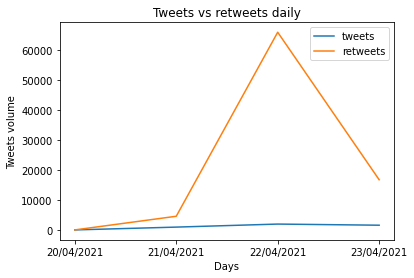

[2, 940, 1953, 1573]
[3, 4562, 66002, 16756]


In [28]:
def DailyTweetsAndRetweets(start, end):
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient["mydatabase"]
    myusers = mydb["users"]
    mytweets = mydb["tweets"]
    current_date = start
    today = ''
    list_days = []
    list_day_tweet_count = []
    list_day_retweet_count = []
    while current_date != end:
        # { "referenced_tweets.type" : "retweeted", { "username" : { "$regex" : current_date } } }
        today = DayMonthYearToPetition(current_date) + ".*"
        tweets_not_retweets = len(list(mytweets.find( {"$and": [ { "referenced_tweets.type" : {"$ne": "retweeted"} }, { "created_at" : { "$regex" : today }} ] } )))
        tweets_retweets = len(list(mytweets.find( {"$and": [ {"referenced_tweets.type" : "retweeted"}, {"created_at" : { "$regex" : today }} ] } )))
        
        list_days.append(current_date)
        list_day_tweet_count.append(tweets_not_retweets)
        list_day_retweet_count.append(tweets_retweets)
        current_date = NextDate(current_date)
    #print plot here
    plt.plot(list_days, list_day_tweet_count, label = "tweets")
    # plotting the line 2 points 
    plt.plot(list_days, list_day_retweet_count, label = "retweets")

    # naming the x axis
    plt.xlabel('Days')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title('Tweets vs retweets daily')
    # show a legend on the plot
    plt.legend()
    # function to show the plot
    plt.show()
    print(list_day_tweet_count)
    print(list_day_retweet_count)
    
DailyTweetsAndRetweets("20/04/2021", "24/04/2021")

### Top-10 most tweeted and retweeted keywords.

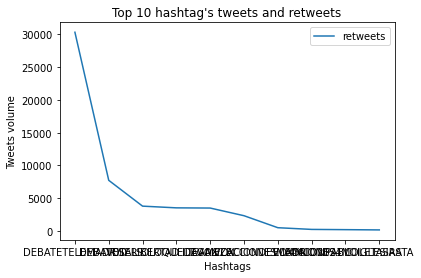

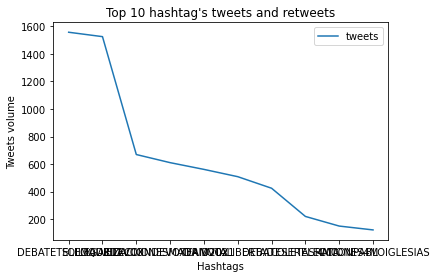

[1558, 1526, 669, 610, 561, 508, 424, 219, 149, 121]
[30309, 7741, 3806, 3545, 3515, 2346, 519, 259, 223, 182]


In [29]:
def Top10MostTweetsAndRetweets():
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient["mydatabase"]
    myusers = mydb["users"]
    mytweets = mydb["tweets"]
    
    hashtag_retweet = {}
    hashtag_tweet = {}

    list_hashtags = []
    list_hashtag_retweet = []
    list_hashtag_tweet = []
    hashtags_list = []
    hashtag = ''
    
    f =  open("./hashtags.txt", "r")
    while True:
        # read line
        try:
            hashtag = f.readline()
            if (hashtag == "") :
                break
        except:
            # datetime object containing current date and time
            now = datetime.datetime.now()
            # dd/mm/YY H:M:S
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            errorlog = open("./errorlog" + d1 + ".txt", "a")
            errorlog.write("Fallo al leer el fichero hashtags.txt " + dt_string + "\n")
            errorlog.close()

        hashtag = hashtag.rstrip('\n')
        hashtag = hashtag.replace('#', '')
        hashtags_list.append(hashtag.upper())
        
    f.close()
    
    for h in hashtags_list:
        tweets_not_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : {"$ne": "retweeted"} }, { "hashtag": h } ] } )))
        tweets_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : "retweeted"}, {"hashtag" : h  } ] } )))
        
        hashtag_retweet[h] = tweets_retweets
        hashtag_tweet[h] = tweets_not_retweets
                        
    sort_hashtag_retweet = sorted(hashtag_retweet.items(), key=lambda x: x[1], reverse=True)
    sort_hashtag_tweet = sorted(hashtag_tweet.items(), key=lambda x: x[1], reverse=True)
    
    for node in sort_hashtag_retweet[0:10]:
        list_hashtag_retweet.append(node[1])
        list_hashtags.append(node[0])
    #print plot here
    plt.figure(0)
    plt.plot(list_hashtags, list_hashtag_retweet, label = "retweets")
    # naming the x axis
    plt.xlabel('Hashtags')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title("Top 10 hashtag's retweets")
    # show a legend on the plot
    plt.legend()
    
    list_hashtags = []
    for node in sort_hashtag_tweet[0:10]:
        list_hashtag_tweet.append(node[1])
        list_hashtags.append(node[0])
    # plotting the line 2 points 
    plt.figure(1)
    plt.plot(list_hashtags, list_hashtag_tweet, label = "tweets")
    # naming the x axis
    plt.xlabel('Hashtags')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title("Top 10 hashtag's tweets")
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()
    print(list_hashtag_tweet)
    print(list_hashtag_retweet)
    
Top10MostTweetsAndRetweets()

### Word clouds with the top-100 most popular words in numbers of tweets and retweets.

In [ ]:
# https://www.datacamp.com/community/tutorials/wordcloud-python

### Keywords popularity over the weeks.

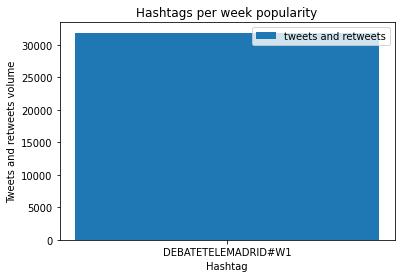

['DEBATETELEMADRID#W1']
[31867]


In [24]:
def datespan(startDate, endDate):
    current_date = startDate
    dat = datetime.datetime.strptime(current_date, "%d/%m/%Y")
    dat += datetime.timedelta(days= (6 - dat.weekday()))
    next_date = dat.strftime("%d/%m/%Y").split(' ')[0]
    if datetime.datetime.strptime(current_date, "%d/%m/%Y") < datetime.datetime.strptime(endDate, "%d/%m/%Y"):
        return endDate
    else: 
        return next_date

def HashtagsPerWeekPopularity(startDate, endDate):
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient["mydatabase"]
    myusers = mydb["users"]
    mytweets = mydb["tweets"]
    
    current_date = startDate
    next_date = ''
    hashtags_list = []
    
    hashtag_count = {}
    
    hashtags_plt = []
    count_plt = []
    f =  open("./hashtags.txt", "r")
    while True:
        # read line
        try:
            hashtag = f.readline()
            if (hashtag == "") :
                break
        except:
            # datetime object containing current date and time
            now = datetime.datetime.now()
            # dd/mm/YY H:M:S
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            errorlog = open("./errorlog" + d1 + ".txt", "a")
            errorlog.write("Fallo al leer el fichero hashtags.txt " + dt_string + "\n")
            errorlog.close()

        hashtag = hashtag.rstrip('\n')
        hashtag = hashtag.replace('#', '')
        hashtags_list.append(hashtag.upper())

    f.close()
    
    gte = ''
    lt = ''
    week_count = 1
    while current_date != endDate:
        next_date = datespan(current_date, endDate)
        for h in hashtags_list:
            gte = DayMonthYearToPetition(current_date) + 'T00:00:0.000Z'
            lt = DayMonthYearToPetition(next_date) + 'T11:59:59.000Z'
            hashtag_count[h] = len(list(mytweets.find( { "$and": [ { 'hashtag' : h }, { 'created_at' : { '$gte' : gte , '$lt' : lt } } ] } )))
        #aqui obtenemos el hashtag con mayor cantida de tweets y retweets y lo insertamos en la lista final
        sort_hashtag_count = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
        hashtags_plt.append(sort_hashtag_count[0][0] + '#W' + str(week_count))
        count_plt.append(sort_hashtag_count[0][1])
        current_date = next_date
        hashtag_count = {}
        week_count += 1
        gte = ''
        lt = ''
        
        
    plt.bar(hashtags_plt, count_plt, label = "tweets and retweets")
    # naming the x axis
    plt.xlabel('Hashtag')
    # naming the y axis
    plt.ylabel('Tweets and retweets volume')
    # giving a title to my graph
    plt.title("Hashtags per week popularity")
    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()
    
   
    print(hashtags_plt)
    print(count_plt)
            

HashtagsPerWeekPopularity("20/04/2021", "24/04/2021")

### Distributions of the number of tweets and retweets per Twitter account.

In [ ]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a):
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y, drawstyle='steps-post')
    plt.grid(True)
    #plt.savefig('ecdf.png')
# no s'e si funciona
def DistributionTweetRetweetAccounts():
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient["mydatabase"]
    myusers = mydb["users"]
    mytweets = mydb["tweets"]
    
    user_retweet_count = []
    user_tweet_count = []

    try:
        tweets = list(mytweets.find())
        users = list(myusers.find())
    except Exception as e:        
        pass
    
    list_hashtags = []
    list_hashtag_retweet = []
    list_hashtag_tweet = []
    
    for u in users:
        tweets_not_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : {"$ne": "retweeted"} }, { "author_id": u['_id'] } ] } )))
        tweets_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : "retweeted"}, {"author_id": u['_id'] } ] } )))
        
        user_retweet_count.append(tweets_retweets)
        user_tweet_count.append(tweets_not_retweets)
    
    xvec = np.array(user_retweet_count)
    plot_ecdf(xvec)
    
    xvec = np.array(user_tweet_count)
    plot_ecdf(xvec)
    
    print(list_hashtag_tweet)
    print(list_hashtag_retweet)
    
DistributionTweetRetweetAccounts()

### Top-5 most active verified user accounts.

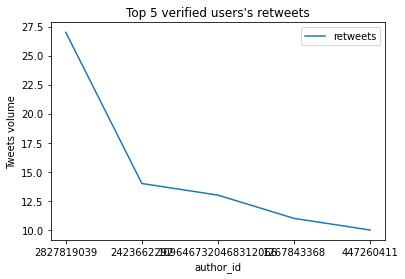

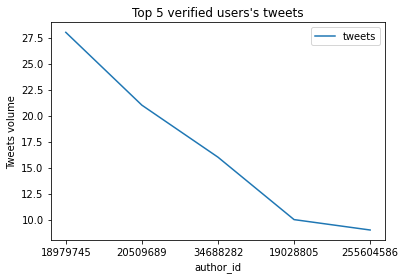

[(ObjectId('000000000000000018979745'), 28), (ObjectId('000000000000000020509689'), 21), (ObjectId('000000000000000034688282'), 16), (ObjectId('000000000000000019028805'), 10), (ObjectId('000000000000000255604586'), 9)]
[(ObjectId('000000000000002827819039'), 27), (ObjectId('000000000000002423662292'), 14), (ObjectId('000001096467320468312066'), 13), (ObjectId('000000000000001267843368'), 11), (ObjectId('000000000000000447260411'), 10)]


In [32]:
def Top5VerifiedUserTweets():
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient["mydatabase"]
    myusers = mydb["users"]
    mytweets = mydb["tweets"]
    
    users = []
    user_retweet = {}
    user_tweet = {}
    
    try:
        users = list(myusers.find( { "verified" : True } ))
    except Exception as e:        
        pass

    list_user = []
    list_user_retweet = []
    list_user_tweet = []
    
    for u in users:
        tweets_not_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : {"$ne": "retweeted"} }, { "author_id": u['_id'] } ] } )))
        tweets_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : "retweeted"}, {"author_id": u['_id'] } ] } )))
        user_retweet[u['_id']] = tweets_retweets
        user_tweet[u['_id']] = tweets_not_retweets
                        
    sort_user_retweet = sorted(user_retweet.items(), key=lambda x: x[1], reverse=True)
    sort_user_tweet = sorted(user_tweet.items(), key=lambda x: x[1], reverse=True)
    
    
    for node in sort_user_retweet[0:5]:
        list_user_retweet.append(node[1])
        list_user.append(str(node[0]).lstrip("0"))
    # plotting the line 2 points 
    plt.figure(1)
    plt.plot(list_user, list_user_retweet, label = "retweets")
    # naming the x axis
    plt.xlabel('author_id')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title("Top 5 verified users's retweets")
    # show a legend on the plot
    plt.legend()
    
    list_user = []
    for node in sort_user_tweet[0:5]:
        list_user_tweet.append(node[1])
        list_user.append(str(node[0]).lstrip("0"))
    #print plot here
    plt.figure(0)
    plt.plot(list_user, list_user_tweet, label = "tweets")
    # naming the x axis
    plt.xlabel('author_id')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title("Top 5 verified users's tweets")
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()

    print(sort_user_tweet[0:5])
    print(sort_user_retweet[0:5])
    
Top5VerifiedUserTweets()

### Co-occurrence networks for tweets and retweets.

### Top-20 LIWC attributes extracted from the collected tweets and retweets.

### Heat map

In [98]:
#https://plotly.com/python/maps/
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely import geometry, ops

In [145]:
myclient = pymongo.MongoClient('localhost', 27017)
mydb = myclient["mydatabase_ejemplos"]
myusers = mydb["users_ejemplos"]
mytweets = mydb["tweets_ejemplos"]

tweet_list = list(mytweets.find( { "place" : {"$ne": ""} } ))
print(str(len(tweet_list)))


# set the filepath and load
fp = 'recintos_autonomicas_inspire_peninbal_etrs89.shp'
#reading the file stored in variable fp
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe

list_names_comunidades = []
aux_list = []
index = 0
contain = False
while index < len(map_df.NAMEUNIT):
    contain = False
    for comunidad in list_names_comunidades:
        if comunidad[0] == map_df.NAMEUNIT[index]:
            #combine two lines
            contain = True
            comunidad[1].append(map_df.geometry[index])
    if contain == False:
        list_names_comunidades.append([map_df.NAMEUNIT[index], [map_df.geometry[index]], 0])
    index += 1
    
print(str(len(list_names_comunidades)))

for comunidad in list_names_comunidades:
    for tweet in tweet_list:
        for posicion in comunidad[1]:
            line = LineString([(tweet['geo']['geo']['bbox'][0], tweet['geo']['geo']['bbox'][1]), (tweet['geo']['geo']['bbox'][2], tweet['geo']['geo']['bbox'][3])])
            if line.distance(posicion) < 0.6:
                comunidad[2] = comunidad[2] + 1
                break
    print(comunidad[0] , comunidad[2])
    

67
19
Territorio no asociado a ninguna autonomía 0
Ciudad Autónoma de Melilla 0
Ciudad Autónoma de Ceuta 0
La Rioja 0
País Vasco/Euskadi 1
Comunidad Foral de Navarra 1
Región de Murcia 0
Comunidad de Madrid 2
Galicia 0
Extremadura 0
Comunitat Valenciana 0
Cataluña/Catalunya 2
Castilla-La Mancha 2
Castilla y León 3
Cantabria 1
Illes Balears 0
Principado de Asturias 1
Aragón 1
Andalucía 1


<AxesSubplot:>

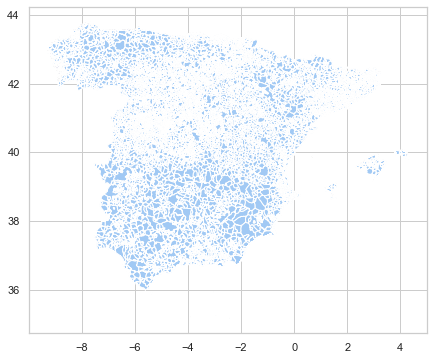

In [135]:

def draw_screen_poly( lats, lons, m):
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon( xy, facecolor='red', alpha=0.4 )
    plt.gca().add_patch(poly)



In [96]:
#opening the csv(.shp) file which contains the data to be plotted on the map
df = gpd.read_file(\\District_Boundary.shp”)
df.head()
#selecting the columns required
df = df[[‘DIST_NAME’,’POPULATION’]]
#renaming the column name
data_for_map = df.rename(index=str, columns={‘NAME_BOUND’: ‘NAME_BOUND’,‘POPULATION’: ‘POP’})

SyntaxError: unexpected character after line continuation character (<ipython-input-96-a0b9e17bebb9>, line 2)

In [137]:
# set the filepath and load
fp = 'recintos_autonomicas_inspire_peninbal_etrs89.shp'
#reading the file stored in variable fp
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe

print(map_df)

                   INSPIREID COUNTRY  \
0   ES.IGN.BDDAE.34200000000      ES   
1   ES.IGN.BDDAE.34200000000      ES   
2   ES.IGN.BDDAE.34190000000      ES   
3   ES.IGN.BDDAE.34180000000      ES   
4   ES.IGN.BDDAE.34170000000      ES   
5   ES.IGN.BDDAE.34160000000      ES   
6   ES.IGN.BDDAE.34150000000      ES   
7   ES.IGN.BDDAE.34140000000      ES   
8   ES.IGN.BDDAE.34130000000      ES   
9   ES.IGN.BDDAE.34120000000      ES   
10  ES.IGN.BDDAE.34110000000      ES   
11  ES.IGN.BDDAE.34100000000      ES   
12  ES.IGN.BDDAE.34090000000      ES   
13  ES.IGN.BDDAE.34080000000      ES   
14  ES.IGN.BDDAE.34070000000      ES   
15  ES.IGN.BDDAE.34060000000      ES   
16  ES.IGN.BDDAE.34040000000      ES   
17  ES.IGN.BDDAE.34030000000      ES   
18  ES.IGN.BDDAE.34020000000      ES   
19  ES.IGN.BDDAE.34010000000      ES   

                                               NATLEV          NATLEVNAME  \
0   https://inspire.ec.europa.eu/codelist/Administ...  Comunidad autónoma   
1   h

In [138]:
# set the filepath and load
fp = 'recintos_provinciales_inspire_peninbal_etrs89.shp'
#reading the file stored in variable fp
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe

print(map_df)

                   INSPIREID COUNTRY  \
0   ES.IGN.BDDAE.34104600000      ES   
1   ES.IGN.BDDAE.34084500000      ES   
2   ES.IGN.BDDAE.34024400000      ES   
3   ES.IGN.BDDAE.34094300000      ES   
4   ES.IGN.BDDAE.34074200000      ES   
5   ES.IGN.BDDAE.34014100000      ES   
6   ES.IGN.BDDAE.34074000000      ES   
7   ES.IGN.BDDAE.34063900000      ES   
8   ES.IGN.BDDAE.34073700000      ES   
9   ES.IGN.BDDAE.34123600000      ES   
10  ES.IGN.BDDAE.34073400000      ES   
11  ES.IGN.BDDAE.34033300000      ES   
12  ES.IGN.BDDAE.34123200000      ES   
13  ES.IGN.BDDAE.34153100000      ES   
14  ES.IGN.BDDAE.34143000000      ES   
15  ES.IGN.BDDAE.34012900000      ES   
16  ES.IGN.BDDAE.34132800000      ES   
17  ES.IGN.BDDAE.34122700000      ES   
18  ES.IGN.BDDAE.34172600000      ES   
19  ES.IGN.BDDAE.34092500000      ES   
20  ES.IGN.BDDAE.34072400000      ES   
21  ES.IGN.BDDAE.34012300000      ES   
22  ES.IGN.BDDAE.34022200000      ES   
23  ES.IGN.BDDAE.34012100000      ES   


In [139]:
# set the filepath and load
fp = 'recintos_municipales_inspire_peninbal_etrs89.shp'
#reading the file stored in variable fp
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe

print(map_df)

                     INSPIREID COUNTRY  \
0     ES.IGN.BDDAE.34091717186      ES   
1     ES.IGN.BDDAE.34091717187      ES   
2     ES.IGN.BDDAE.34091717188      ES   
3     ES.IGN.BDDAE.34091717189      ES   
4     ES.IGN.BDDAE.34091717190      ES   
...                        ...     ...   
8124  ES.IGN.BDDAE.34091717181      ES   
8125  ES.IGN.BDDAE.34091717182      ES   
8126  ES.IGN.BDDAE.34091717183      ES   
8127  ES.IGN.BDDAE.34091717184      ES   
8128  ES.IGN.BDDAE.34091717185      ES   

                                                 NATLEV NATLEVNAME  \
0     https://inspire.ec.europa.eu/codelist/Administ...  Municipio   
1     https://inspire.ec.europa.eu/codelist/Administ...  Municipio   
2     https://inspire.ec.europa.eu/codelist/Administ...  Municipio   
3     https://inspire.ec.europa.eu/codelist/Administ...  Municipio   
4     https://inspire.ec.europa.eu/codelist/Administ...  Municipio   
...                                                 ...        ...   
8124 